# Time-dependent problems

Below are the packages and some convenient toll functions used in the assignment.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from numba import cuda, float64, prange, njit

# the wanted solution to when does the center reach u=1
t_expect = 0.424011387033


# to estimate the efficiency of different methods
class Timer:
    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, *args):
        self.end = time.perf_counter()
        self.interval = self.end - self.start


# a tool: if there is remaider quotient + 1
def div_ceil(dividend, divisor):
    quotient = dividend // divisor
    remainder = dividend % divisor

    if remainder:
        return quotient + 1
    else:
        return quotient


# generate the t0 plate (1D)
def t_0_generator(N):
    t_0 = np.zeros((N, N), dtype=np.float64)
    t_0[:, 0] = 5
    t_0.resize((N**2,))
    return t_0

## explicit time-stepping (Forward Euler)

Forward-Euler is used in the explicit part. Methods with and without CUDA are both implemented in this part.

As the explict methods are sensitive to the time step, time step which is too large often raises unstability.

To make the whole process stable, CFL condition should be satisfied.

2D CFL condition gives that:
$$
\sqrt{\left(\frac{c_x \Delta t}{\Delta x}\right)^2 + \left(\frac{c_y \Delta t}{\Delta y}\right)^2} \leq 1
$$
which means when
$$
u^{n+1}_{i,j} = u^n_{i,j} + \alpha \Delta t \left( \frac{u^n_{i+1,j} + u^n_{i-1,j} + u^n_{i,j+1} + u^n_{i,j-1} - 4u^n_{i,j}}{\Delta x^2} \right)
$$
time step $\Delta t$ and $\Delta x$ should satisfy:
$$
\Delta t \leq \frac{1}{4} \Delta x^2
$$
In this assignment as the plate is a square plate with side lenth $L = 2$, thus:
$$
\Delta t \leq \frac{1}{N^2}
$$


### without cuda

`@numba.njit` and `numba.prange` is used to accelerate the computation. Thus, the work in the for loop are carried out in parallel.

In [ ]:
@njit
def forward_euler(N,dt,x):
    u_new = x.copy()
    k = dt / (4 / ((N-1)**2))

    u = np.zeros((N, N), dtype=np.float64)
    centre = N**2 // 2
    counter = 0
    time_reached = 0

    while u_new[centre] <= 1:
        u = u_new.copy()
        for i in prange(1, N - 1):
            for j in range(1, N - 1):
                u_new[i * N + j] = (1 - 4 * k) * u[i * N + j] + k * (
                    u[(i - 1) * N + j]
                    + u[(i + 1) * N + j]
                    + u[i * N + j + 1]
                    + u[i * N + j - 1]
                )
        counter += 1

    time_reached = counter * dt

    return u_new,time_reached

Below is the sample use of the function with the grid $31*31$ and $\Delta t = 0.001$ . It retures the final plate and the time used when the mid of the plate hits 1 Celsius degree.

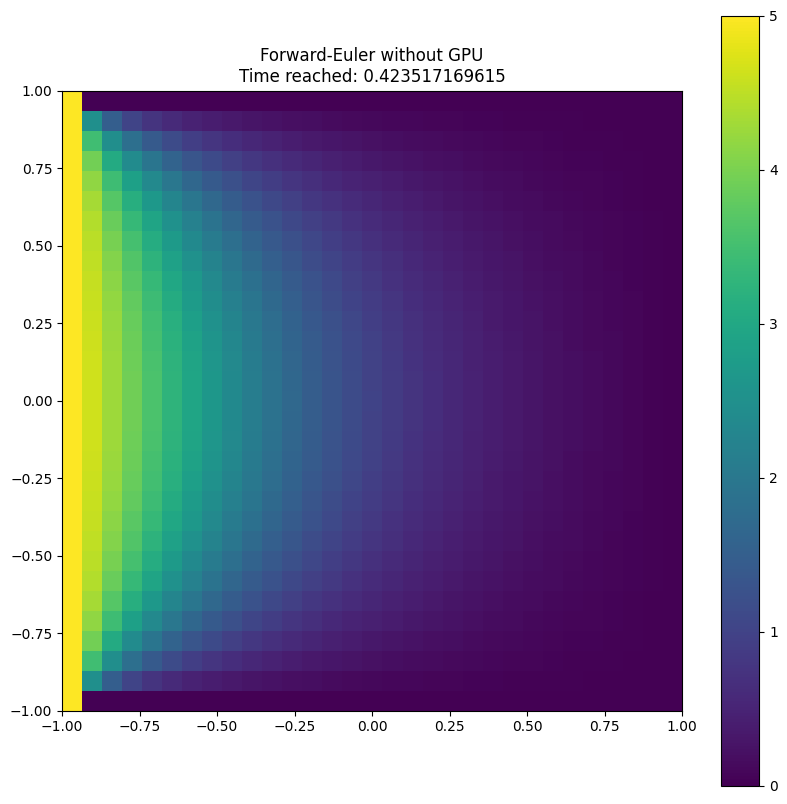

In [ ]:
N = 31
dt = 1/N**2 # implement the condition of stability
x,time_reached = forward_euler(N,dt,t_0_generator(N))
u_final = x.reshape((N, N))

# Plot the results
plt.figure(figsize=(10, 10))

plt.title(f"Forward-Euler without GPU\nTime reached: {time_reached:.12f}")
plt.imshow(u_final, extent=[-1, 1, -1, 1], origin="lower")

plt.colorbar()
plt.show()

### with cuda

In this section, CUDA is used to further accelerate the computation. For that the GPU can run more threads than CPU in parallel, it is more efficient to carry out calculations on GPU when dealing with a considerable large matrix (when the matrix is small, the two are likely to be close in effeciency).

In [ ]:
def explicit_matrix_generator_GPU(N, dt):
    size = N**2

    nelements = 5 * size - 16 * N + 16
    d_u = 2 / (N-1)

    k = dt / (d_u**2)

    row_ind = np.zeros(nelements, dtype=np.float64)
    col_ind = np.zeros(nelements, dtype=np.float64)
    data = np.zeros(nelements, dtype=np.float64)

    count = 0

    for i in range(N):
        for j in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = i * N + j
                col_ind[count] = 2
                data[count] = 1
                count += 1
            else:
                row_ind[count : count + 5] = i * N + j

                col_ind[count] = 2
                col_ind[count + 1] = 0
                col_ind[count + 2] = 4
                col_ind[count + 3] = 1
                col_ind[count + 4] = 3

                data[count] = -4 * k + 1
                data[count + 1 : count + 5] = 1 * k

                count += 5

    return coo_matrix((data, (row_ind, col_ind)), shape=(size, 5)).tocsc()

The matrix generator above produces a $N * 5$ matrix whose shape is shown as below. This structure makes it easier to load data to the shared memory.

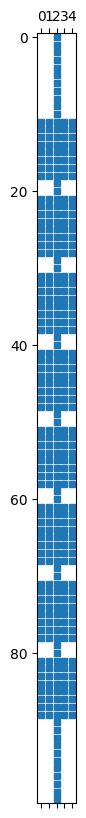

In [ ]:
plt.figure(figsize=(10, 10))
plt.spy(explicit_matrix_generator_GPU(10,0.01), markersize=5)
plt.show()

Below is the method. In the first kernel, the shape of each block is set to $6*5$ which can deal with 6 points, and it can automatically change the shape of the grid according to the number of grids. The details of the kernels are explained in the comments.

In [ ]:
def forward_euler_with_GPU(N, dt):
    N_square = N**2
    N_square_5 = 5 * N_square
    N_square_last_N = N_square - N

    centre = N_square // 2

    blk_num_1=div_ceil(N_square, 6) # calculate the block num in the first kernel
    blk_num_2=div_ceil(N_square, 32) # calculate the block num in the second kernel

    x = t_0_generator(N)
    A = explicit_matrix_generator_GPU(N, dt).toarray()
    b = np.zeros(N_square, dtype=np.float64)
    centre_temp = np.zeros(1, dtype=np.float64)

    A_device = cuda.to_device(A)
    B_device = cuda.to_device(x)
    C_device = cuda.to_device(b)
    centre_temp_device = cuda.to_device(centre_temp)

    # a and b is the coeffient from y=a*x**3+b*x which pass the points:
    # (-N,-N),(-1,-1),(0,0),(1,1),(N,N)
    # thus improving the efficiency by removing 'if's
    a=(N-2)/6
    b=(8-N)/6

    @cuda.jit
    def fast_PDE_matvec(A, B, C):
        # load data from global memory to shared memory
        sA = cuda.shared.array(shape=(6, 5), dtype=float64)
        sB = cuda.shared.array(shape=(6, 5), dtype=float64)

        x, y = cuda.grid(2)
        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y

        sA[tx, ty] = A[x, ty] # load data from A
        cuda.syncthreads()

        if x * 5+y <= N_square_5:
            if (x + tx <= N) or (x >= N_square_last_N):
                if ty == 2:
                    sB[tx, ty] = B[x]
                elif ty == 0 or ty == 1 or ty == 3 or ty == 4:
                    sB[tx, ty] = 0
            else:
                sB[tx, ty] = B[x +int(a*(ty-2)**3+b*(ty-2))] # to avoid using too much ifs

            cuda.syncthreads()

            temp = sA[tx, ty] * sB[tx, ty]
            cuda.atomic.add(C, x, temp) # avoid collision
            cuda.syncthreads()

    @cuda.jit
    def update_and_reset(B, C, centre_temp):
        # prepare for the next loop
        x = cuda.grid(1)
        if x < B.size:
            if x==centre:
                centre_temp[0] = C[x]

            B[x] = C[x]
            C[x] = 0.0

    counter = 0
    while centre_temp[0] <= 1:
        fast_PDE_matvec[(blk_num_1,), (6, 5)](A_device, B_device, C_device)
        update_and_reset[(blk_num_2,), (32,)](B_device, C_device, centre_temp_device) # prepare for the next loop
        centre_temp=centre_temp_device.copy_to_host()
        counter += 1

    B_host = B_device.copy_to_host()
    time_reached = counter * dt

    return B_host, time_reached

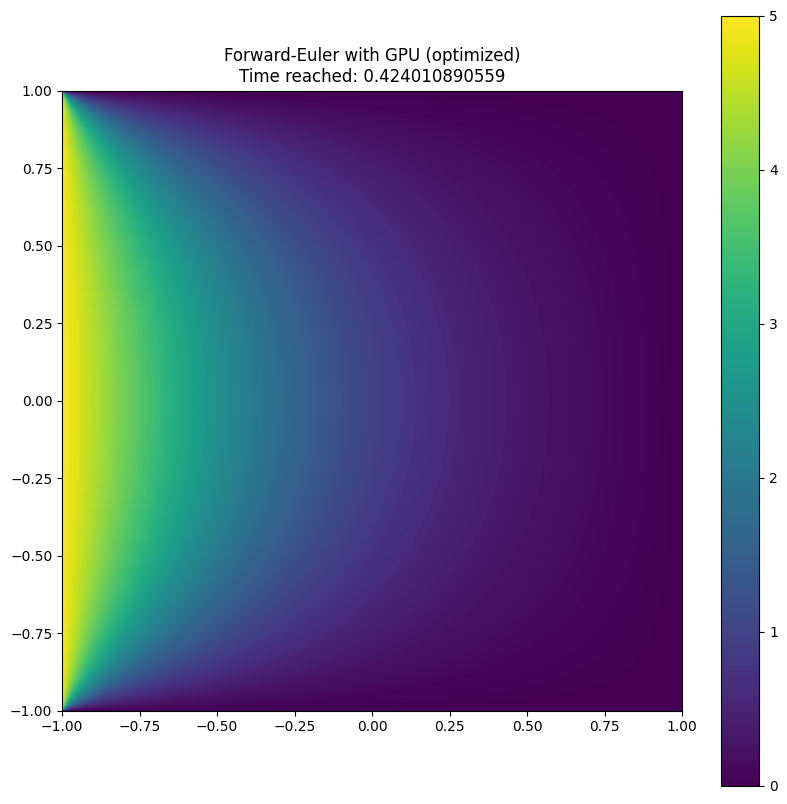

In [ ]:
N = 1401
dt = 1/N**2 # implement the condition of stability

B_host,time_reached = forward_euler_with_GPU(N,dt)

u_final = B_host.reshape((N, N))

# Plot the results
plt.figure(figsize=(10, 10))
plt.title(f"Forward-Euler with GPU (optimized)\nTime reached: {time_reached:.12f}")
plt.imshow(u_final, extent=[-1, 1, -1, 1], origin="lower")
plt.colorbar()
plt.show()

### Comparison (CUDA vs no CUDA)

In [ ]:
N = 225
dt = 1/N**2 # implement the condition of stability
print("GPU: ")
%timeit forward_euler_with_GPU(N, dt)
print("CPU: ")
%timeit forward_euler(N,dt,t_0_generator(N))

GPU: 
4.34 s ± 503 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CPU: 
4.83 s ± 478 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
N = 301
dt = 1/N**2 # implement the condition of stability
print("GPU: ")
%timeit forward_euler_with_GPU(N, dt)
print("CPU: ")
%timeit forward_euler(N,dt,t_0_generator(N))

GPU: 
7.88 s ± 458 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
CPU: 
16.9 s ± 473 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It can be seen that when N is small, the two speed is close. When the N become large, GPU is faster. Thus, I will use the with-CUDA def for explicit method in the following sections.

### Convergence of explicit method (Forward-Euler) with CUDA

In [ ]:
N_list = np.linspace(11, 961, 20)
list_time_explicit = []
for n in N_list:
    N = int(n)
    dt = 1 / N**2  # implement the condition of stability

    u, time_reached = forward_euler_with_GPU(N, dt)
    list_time_explicit.append(time_reached)


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(N_list, list_time_explicit, marker='o', linestyle='-', color='b')
plt.axhline(y=1, color='r', linestyle='-')

# Annotating each data point with its time value
for i, txt in enumerate(list_time_explicit):
    plt.annotate(f"{txt:.8f}", (N_list[i], list_time_explicit[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('N')
plt.ylabel('Time')
plt.title('Time vs N with Data Points')
plt.grid(True)
plt.show()

## implicit time-stepping (Backward Euler)

For implicit method such as Backward-Euler, they are not sensitive to the size of time step. However, it comes with complex computation to solve the linear equtions, small time steps will greatly increase the running time. Thus, in the following sections, I will use 0.0001 as a fix time step to control the excution time in a reasonable range

In [ ]:
def implicit_matrix_generator(N, dt):
    size = N**2
    nelements = 5 * size - 16 * N + 16
    d_u = 2 / (N-1)
    k = dt / (d_u**2)

    row_ind = np.zeros(nelements, dtype=np.float64)
    col_ind = np.zeros(nelements, dtype=np.float64)
    data = np.zeros(nelements, dtype=np.float64)

    count = 0

    for i in range(N):
        for j in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = i * N + j
                data[count] = 1
                count += 1
            else:
                row_ind[count : count + 5] = i * N + j

                col_ind[count] = i * N + j
                col_ind[count + 1] = (i - 1) * N + j
                col_ind[count + 2] = (i + 1) * N + j
                col_ind[count + 3] = i * N + j - 1
                col_ind[count + 4] = i * N + j + 1

                data[count] = 4 * k + 1
                data[count + 1 : count + 5] = -1 * k

                count += 5

    return coo_matrix((data, (row_ind, col_ind)), shape=(size, size)).tocsr()

In [ ]:
def bacward_euler(N, dt):
    x = t_0_generator(N)
    A = implicit_matrix_generator(N, dt)

    N_square = N**2
    centre = N_square // 2

    mid = 0
    time_reached = 0
    counter = 0

    while mid <= 1:
        x = spsolve(A, x)
        mid = x[centre]

        counter += 1
    time_reached = counter * dt

    return x, time_reached

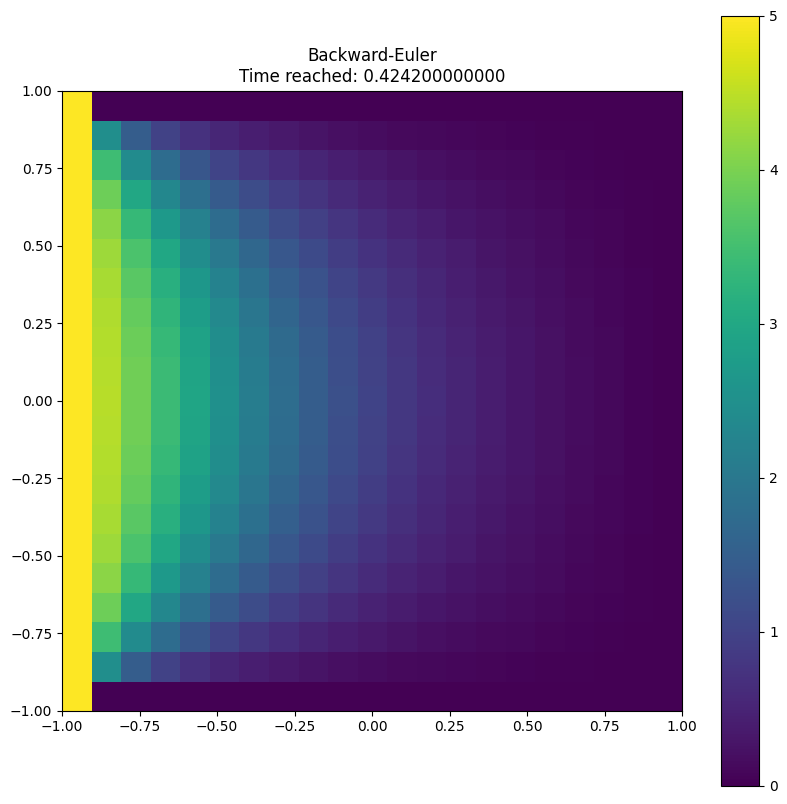

In [ ]:
N = 21
dt = 0.0001

x, time_reached = bacward_euler(N, dt)

u_final = x.reshape((N, N))

# Plot the results
plt.figure(figsize=(10, 10))
plt.title(f"Backward-Euler\nTime reached: {time_reached:.12f}")
plt.imshow(u_final, extent=[-1, 1, -1, 1], origin="lower")
plt.colorbar()
plt.show()

In [ ]:
N_list = np.linspace(1, 21, 11)
list_time_implicit = []
for n in N_list:
    N = int(n)
    dt = 1 / N**2  # implement the condition of stability

    u, time_reached = forward_euler_with_GPU(N, dt)
    list_time_implicit.append(time_reached)


In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(N_list, list_time_implicit, marker='o', linestyle='-', color='b')
plt.axhline(y=1, color='r', linestyle='-')

# Annotating each data point with its time value
for i, txt in enumerate(list_time_implicit):
    plt.annotate(f"{txt:.4f}", (N_list[i], list_time_implicit[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('N')
plt.ylabel('Time')
plt.title('Time vs N with Data Points')
plt.grid(True)
plt.show()